
# Model Development and Parameter Tuning



The model pipeline consists of a hybrid-ML technique, utilizing two separate and optimized frameworks outlined in the figure below.Hybrid approaches in ML modeling, thogh more complex, show improved accuracy over traditional single algorithm models. The integration of multiple algorithms allows for more robust models and methods of feature set derivation.
Here, we apply a hybrid approach of first utilizing Gradient Boosted decision Trees to select an optimal model feature space, and follow it with a supervised MLP regression model. Output of the hybrid model is 1-km gridded SWE estimates throughout the study area.

<img align = 'center' src="./Images/SWE_model_workflow_V2.png" alt = 'drawing' width = '400'/>

### Feature Selection With Gradient Boosted Decision Trees





Import the necessary dependencies and path to the parent directory of the model

In [1]:
import os
import time

import re
import copy
import numpy as np
import pandas as pd
import h5py
import tables
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
#import contextily as cx
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import rioxarray as rxr
import math
import pickle
from pickle import dump
import sklearn
import graphviz
import xgboost as xgb
import lightgbm as lgbm
from platform import python_version

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from xgboost import cv
from xgboost import XGBRegressor
from xgboost import plot_importance as plot_importance_XGB
from lightgbm import LGBMRegressor
from lightgbm import plot_importance as plot_importance_LGBM

print(pd.__version__) # should be 1.3.0
print(sklearn.__version__) # should be 0.24.1
print(python_version()) 

#os.chdir('Your Model Directory Here')
#print(os.getcwd())

C:\Users\rjohnson18\Anaconda3\envs\NSM_env\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
C:\Users\rjohnson18\Anaconda3\envs\NSM_env\lib\site-packages\xarray\backends\cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


1.4.3
1.1.1
3.9.12


## Define Region
The first step is to define the Region, here we are using the Northern Colorado Rockies region.

In [2]:
### load regionalized geospatial data

### define regions
Region_list = ['N_Co_Rockies']

### Load H5 train files into dictionary
RegionTrain= {}
for region in Region_list:
    RegionTrain[region] = pd.read_hdf('./Provided_Data/Final_Training_DF.h5', region)
    

## Define Hyperparameter Grid
Next define a hyperparameter grid dictionary object to be optimized later on during cross-validation splittling. 
The ranges here have been tuned to provide good model performance, however you should change the values around and try additional hyperparameters to see how it affects performance and efficieny. 

In [3]:
### hyperparameter grid

LGBM_param_grid = {
    "max_depth": list(range(3,30,4)),
    "num_leaves": list(range(5,55,10)),
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "n_estimators": list(range(300,700,100))  
}

## Make Dataframe Function
Now we are ready to define our Gradient Boosting Decision Tree Model. 
First, initializing the class parameters and creating the make_dataframe method. 
This method formats a dataframe of the data for use in the model.  

In [10]:
def make_dataframe(region, data):
    """Dataframe manipulation."""

    df = data.get(region)

    ### replace -9999s with nans
    df=df.replace([-9999, -9999.99], np.nan)     

    ### create new index 0 - len(df)
    df= df.reset_index(drop=False)
    df =df.rename(columns={"index": "cell_id"})
    if 'Date' in df.columns:
        df = df.drop(columns=['Date']) 

    ###create indexed series of cell ids
    id_map = df.pop('cell_id').to_frame()
    id_map['Long'] = df['Long']
    id_map['Lat'] = df['Lat']
    id_map['WYWeek'] = df['WYWeek']
    id_map['elevation_m'] = df['elevation_m']

    ### shuffle dataframe
    df = df.sample(frac=1, random_state=1234)

    ### replace special character ':' with '__' 
    df = df.rename(columns = lambda x:re.sub(':', '__', x))

    return df, id_map


## Define Fit function
Now we define the fit_ method. 
This scales the dataframe from the previous step with a Min-Max scaler and splits the data to 25/75% training/testing split. 
A cross-vaildation grid search with 5 folds is then performed on the data for the LGBM_param_grid. 
We select the best parameters using the .best_params_ parameter and fit the model to those parameters.

The fit model now undergoes the first feature selection with the .Feature_Selection method we define in the next block. 

In [12]:
 def fit_(self, region, cv=5):
        """Gridsearch for Parmas, Fit model, and save as instance attribute."""
        start_time = time.time()

        ### Dataframe engineering step
        df, id_map = self.make_dataframe(region, self.data)

        y = df.pop(self.target)


        ###normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(df)
        df = pd.DataFrame(scaled, columns = df.columns)
        #save scaler data here
        pickle.dump(scaler, open('/Model/Model_Training/Prev_LGBM/Scalers/'+'LGBM_'+region+'_scaler.pkl', 'wb'))

        X = df
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)


        ### Fit CV to define optimal hyperparmaeters
        gs = GridSearchCV(
            self.estimator(),
            self.param_grid,
            cv=5,
            n_jobs=-1,
            return_train_score=True,
            refit=False
        )

        gs.fit(X_train, y_train)

        self.best_score = gs.best_score_
        self.param_grid = gs.best_params_
        print('Best Score:', gs.best_score_)
        print('Best Params:', gs.best_params_)


        ### Fit the estimator model with the optimal params
        self.model = self.estimator(**self.param_grid)

        X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = self.Feature_selection(X_train, X_test, y_train, y_test)

        c_time = round(time.time() - start_time,2)
        print('Training time', round(c_time), 's')

        return X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe, id_map


## Feature Selection Function
Here we define the [Recursive Feature Elimination (RFE)](https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html#:~:text=Recursive%20feature%20elimination%20(RFE)%20is,number%20of%20features%20is%20reached.).
Using the sklearn RFECV() function, a minimum of 1 optimal features are chosen for the region based on a 5-fold cross validation. 
The less informing features are ten dropped from the train and test dataframes.

In [13]:
def Feature_selection(self, X_train, X_test, y_train, y_test):
        """Identify and and fit model with optimal features """
        ### Define RFE with CV model
        min_features_to_select = 1  # Minimum number of features to consider
        rfecv = RFECV(
            estimator=self.model,
            step=1,
            cv=5,
            n_jobs=-1,
            min_features_to_select=min_features_to_select,
        )

        rfecv.fit(X_train, y_train)

        ### dataframe of optimal features, remove non-optimal features from train/test data 
        feat = {'Features_raw': X_train.columns}
        RFECV_Feat = pd.DataFrame(data=feat)
        RFECV_Feat['Rank']= rfecv.ranking_
        RFECV_Feat['Selected']= rfecv.support_
        RFECV_Feat_opt = RFECV_Feat[RFECV_Feat['Selected']==True]
        RFECV_Feat_opt = RFECV_Feat_opt['Features_raw']
        RFECV_Feat_opt.columns=['Features_opt']
        print('The optimal features are: ', list(RFECV_Feat_opt))
        ### use optimal features for final fit data
        X_train=X_train[list(RFECV_Feat_opt)]
        X_test=X_test[list(RFECV_Feat_opt)]

        ### fit model with optimal parmas & optimal # of featuress
        self.model = self.estimator(**self.param_grid)
        self.model.fit(X_train, y_train)


        ### Plot number of features vs. cross-validation scores
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (accuracy)")
        plt.plot(range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
            rfecv.cv_results_["mean_test_score"])
        plt.show()

        print("Optimal number of features : %d" % rfecv.n_features_)

        ### Revert special character '__' with ':'
        X_train = X_train.rename(columns = lambda x:re.sub(r"(_)\1+", ':', x))
        X_test = X_test.rename(columns = lambda x:re.sub(r"(_)\1+", ':', x))

        return X_train, X_test, y_train, y_test



## Prediction Function
Next we may define a .predict_ method on the Decision tree model to predict SWE against the test locations. 
We will ultimately not use this prediction as the Nueral Net proves more robust, however it can be insightful for comparing the diffent algorithm performance. 

In [14]:
def predict_(self, X_test):
        """Generate model predictions."""

        preds = (self.model.predict(X_test))

        ### correct negative predictions
        preds[preds <0]=0

        return preds


## Batch Training Function
Rather than indivdually call each method, we can create a new method, called .Batch_Train that will run through the steps we just defined. 
This will take in our paramater objects and return a pickle file of the optimal features ("opt_features_final.pkl) for the region that will be used to train the Neural Net in the following steps. 

In [4]:
def Batch_Train(target, data, algorithm, parameter_grid, Region_list):
    """
    Batch train regression model and produce testing prediction.
    Args:
        algorithm (model object): Regressor to be fit (XGBRegressor, LGBMRgressor)
        param_grid (dict): Hyperparameter grid
        Region_list (list): List of regions to be evaluated
    """

    split_dict={}
    prediction_dict={}
    features_dict = {}
    ### define prefix for path based on algorithm desired
    if algorithm == XGBRegressor:
        path_name = 'XGB'
        from xgboost import plot_importance
    elif algorithm == LGBMRegressor:
        path_name = 'LGBM'
        from lightgbm import plot_importance
    else:
        raise ValueError("Algorithm not recognized. Must be XGBRegressor or LGBMRegressor.")

    for region in Region_list:
        ###Instantiate Model
        region_model = REGRESSOR(target=target, data=data, estimator=algorithm, param_grid=parameter_grid)

        ###Fit region model and add dictionary entry for region test-train data, save fit model to file.
        ###Dictformat is, split_dict{'region': [X_train, X_test, y_train, y_test, cell_id]}
        print(region,':')
        split_dict[region] = region_model.fit_(region)
        print('Saving Model')
        pickle.dump(region_model, open("./Model/Model_Training/LGBM/LGBM_"+region+".pkl", "wb"))

        ###Generate predictions and add to prediction dictionary,
        ###Dict format is, prediction_dict{'region': [preds]}
        prediction_dict[region] = region_model.predict_(split_dict.get(region)[1])

        ### plot predictions if desired
        fig, ax =plt.subplots()
        sns.set(style="whitegrid")
        plt.scatter(split_dict.get(region)[3], prediction_dict.get(region), marker='.',s=100, color = 'b')
        plt.plot([0,(prediction_dict.get(region).max()+10)], [0,(prediction_dict.get(region).max()+10)], ls="--", c=".1")
        plt.xlim([0, (split_dict.get(region)[3].max()+5)])
        plt.ylim([(prediction_dict.get(region).min()-1),(prediction_dict.get(region).max()+5)])
        ax.set_title(region)
        ax.set_xlabel("Truth")
        ax.set_ylabel("Prediction")
        plt.show()
        rmse = mean_squared_error(split_dict.get(region)[3], prediction_dict.get(region), squared=False)
        print(region, "RMSE:", (round(rmse,3)))

        ###Optimal Features dictionary 
        features_dict[region] = split_dict[region][0].columns


    ###Save output dictionaries to file
    pickle.dump(split_dict, open("./Model/Model_Training/LGBM/Output/"+path_name+"_split_dict_final.pkl", "wb"))
    pickle.dump(prediction_dict, open("./Model/Model_Training/LGBM/Output/"+path_name+"_prediction_dict_final.pkl", "wb"))
    pickle.dump(features_dict, open("./Model/Model_Training/LGBM/Output/opt_features_final.pkl", "wb"))

    return split_dict, prediction_dict



##  REGRESSOR Class
We defined all of the key functions of the LightGBM framework but need a method for each function to "talk" to another.
Addressing this, we develop a [Object Oriented Programming (OOB)](https://realpython.com/python3-object-oriented-programming/) function that we label the REGRESSOR Class
In the REGRESSOR class, we place all of the functions within and use the self. command to support variable "pointing".

In [7]:
class REGRESSOR(object):
    """
    Regression optimization model class.
    Args:
        target (str): target to be modeled.
        data (dict): Dictionary of dataframes containing training/testing data
        estimator (model object): type of model to be fit.
        param_grid (dict): hyperparameter grid
        model (fit XGBRegressor, LGBMRegessor, etc..): the fit model object
    """

    def __init__(self, target, data, estimator=None, param_grid=None, model=None):
        self.target = target
        self.data = data
        self.estimator = estimator 
        self.param_grid = param_grid
        self.model = model
    
        #@staticmethod
    def make_dataframe(self, region, data):
        """Dataframe manipulation."""
        print('Making training dataframe.')
        df = data.get(region)
        
        ### replace -9999s with nans
        df=df.replace([-9999, -9999.99], np.nan)     
        
        ### create new index 0 - len(df)
        df= df.reset_index(drop=False)
        df =df.rename(columns={"index": "cell_id"})
        if 'Date' in df.columns:
            df = df.drop(columns=['Date']) 
        
        ###create indexed series of cell ids
        id_map = df.pop('cell_id').to_frame()
        id_map['Long'] = df['Long']
        id_map['Lat'] = df['Lat']
        id_map['WYWeek'] = df['WYWeek']
        id_map['elevation_m'] = df['elevation_m']

        ### shuffle dataframe
        df = df.sample(frac=1, random_state=1234)
        
        ### replace special character ':' with '__' 
        df = df.rename(columns = lambda x:re.sub(':', '__', x))
        
        return df, id_map
    
    def fit_(self, region, cv=5):
        print('Fitting the model.')
        """Gridsearch for Parmas, Fit model, and save as instance attribute."""
        start_time = time.time()

        ### Dataframe engineering step
        df, id_map = self.make_dataframe(region, self.data)

        y = df.pop(self.target)


        ###normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(df)
        df = pd.DataFrame(scaled, columns = df.columns)
        #save scaler data here
        pickle.dump(scaler, open('./Model/Model_Training/LGBM/Scalers/'+'LGBM_'+region+'_scaler.pkl', 'wb'))

        X = df
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)


        ### Fit CV to define optimal hyperparmaeters
        gs = GridSearchCV(
            self.estimator(),
            self.param_grid,
            cv=5,
            n_jobs=-1,
            return_train_score=True,
            refit=False
        )
        print('Performing the LGBM GridSearch to identify optimal hyperparameters.')
        gs.fit(X_train, y_train)

        self.best_score = gs.best_score_
        self.param_grid = gs.best_params_
        print('Best Score:', gs.best_score_)
        print('Best Params:', gs.best_params_)


        ### Fit the estimator model with the optimal params
        self.model = self.estimator(**self.param_grid)
        print('Optimizig Features')
        X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = self.Feature_selection(X_train, X_test, y_train, y_test)

        c_time = round(time.time() - start_time,2)
        print('Training time', round(c_time), 's')

        return X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe, id_map


    def Feature_selection(self, X_train, X_test, y_train, y_test):
        """Identify and and fit model with optimal features """
        ### Define RFE with CV model
        min_features_to_select = 1  # Minimum number of features to consider
        rfecv = RFECV(
            estimator=self.model,
            step=1,
            cv=5,
            n_jobs=-1,
            min_features_to_select=min_features_to_select,
        )

        rfecv.fit(X_train, y_train)

        ### dataframe of optimal features, remove non-optimal features from train/test data 
        feat = {'Features_raw': X_train.columns}
        RFECV_Feat = pd.DataFrame(data=feat)
        RFECV_Feat['Rank']= rfecv.ranking_
        RFECV_Feat['Selected']= rfecv.support_
        RFECV_Feat_opt = RFECV_Feat[RFECV_Feat['Selected']==True]
        RFECV_Feat_opt = RFECV_Feat_opt['Features_raw']
        RFECV_Feat_opt.columns=['Features_opt']
        print('The optimal features are: ', list(RFECV_Feat_opt))
        ### use optimal features for final fit data
        X_train=X_train[list(RFECV_Feat_opt)]
        X_test=X_test[list(RFECV_Feat_opt)]

        ### fit model with optimal parmas & optimal # of featuress
        self.model = self.estimator(**self.param_grid)
        self.model.fit(X_train, y_train)


        ### Plot number of features vs. cross-validation scores
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (accuracy)")
        plt.plot(range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
            rfecv.cv_results_["mean_test_score"])
        plt.show()

        print("Optimal number of features : %d" % rfecv.n_features_)

        ### Revert special character '__' with ':'
        X_train = X_train.rename(columns = lambda x:re.sub(r"(_)\1+", ':', x))
        X_test = X_test.rename(columns = lambda x:re.sub(r"(_)\1+", ':', x))

        return X_train, X_test, y_train, y_test
        

    def predict_(self, X_test):
        """Generate model predictions."""
        print('Making a prediction on testing data.')
        preds = (self.model.predict(X_test))

        ### correct negative predictions
        preds[preds <0]=0

        return preds

## Running the LightGBM for Feature Optimization
Finally, we can enter our parameter values into the Batch_Train method and have the model define our optimal features. These feature are crucial for training the Neural Network.

N_Co_Rockies :
Fitting the model.
Making training dataframe.
Performing the LGBM GridSearch to identify optimal hyperparameters.
Best Score: 0.8568292366930509
Best Params: {'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 400, 'num_leaves': 25, 'subsample': 0.7}
Optimizig Features
The optimal features are:  ['Long', 'Lat', 'elevation_m', 'prev_SWE', 'WYWeek', 'northness', 'SWE_SNOTEL__1014_CO_SNTL', 'SWE_SNOTEL__1030_CO_SNTL', 'SWE_SNOTEL__1031_CO_SNTL', 'SWE_SNOTEL__1032_CO_SNTL', 'SWE_SNOTEL__1033_CO_SNTL', 'SWE_SNOTEL__1040_CO_SNTL', 'SWE_SNOTEL__1061_CO_SNTL', 'SWE_SNOTEL__1100_CO_SNTL', 'SWE_SNOTEL__1101_CO_SNTL', 'SWE_SNOTEL__1120_CO_SNTL', 'SWE_SNOTEL__1122_CO_SNTL', 'SWE_SNOTEL__1123_CO_SNTL', 'SWE_SNOTEL__1141_CO_SNTL', 'SWE_SNOTEL__1161_CO_SNTL', 'SWE_SNOTEL__1186_CO_SNTL', 'SWE_SNOTEL__1187_CO_SNTL', 'SWE_SNOTEL__1251_CO_SNTL', 'SWE_SNOTEL__1252_CO_SNTL', 'SWE_SNOTEL__322_CO_SNTL', 'SWE_SNOTEL__335_CO_SNTL', 'SWE_SNOTEL__345_CO_SNTL', 'SWE_SNOTEL__380_CO_SNTL', 'SWE_S

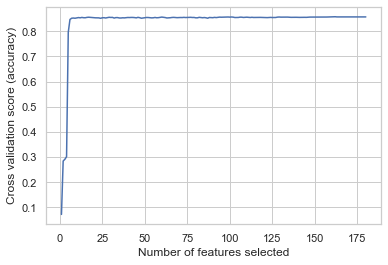

Optimal number of features : 162
Training time 4389 s
Saving Model
Making a prediction on testing data.


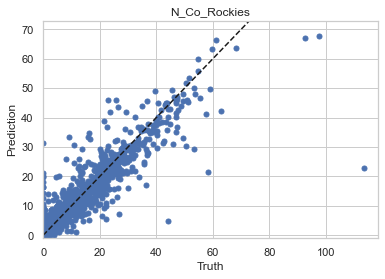

N_Co_Rockies RMSE: 4.268
CPU times: total: 4min 10s
Wall time: 1h 13min 9s


In [9]:
%%time
splits_LGBM , preds_LGBM = Batch_Train('SWE', RegionTrain, LGBMRegressor, LGBM_param_grid, Region_list)

Next [Chapter](./training.ipynb).. 